In [74]:
!pip install ultralytics opencv-contrib-python segment-anything cvlib
!pip install diffusers transformers accelerate
!pip install torch torchvision
!pip install opencv-python-headless

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [75]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import numpy as np
import cv2

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32
).to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [78]:
coco_class_ids = {
    'person': 0,
    'bicycle': 1,
    'car': 2,
    'motorcycle': 3,
    'airplane': 4,
    'bus': 5,
    'train': 6,
    'truck': 7,
    'boat': 8,
    'traffic light': 9,
    'fire hydrant': 10,
    'stop sign': 11,
    'parking meter': 12,
    'bench': 13,
    'bird': 14,
    'cat': 15,
    'dog': 16,
    'horse': 17,
    'sheep': 18,
    'cow': 19,
    'elephant': 20,
    'bear': 21,
    'zebra': 22,
    'giraffe': 23,
    'backpack': 24,
    'umbrella': 25,
    'handbag': 26,
    'tie': 27,
    'suitcase': 28,
    'frisbee': 29,
    'skis': 30,
    'snowboard': 31,
    'sports ball': 32,
    'kite': 33,
    'baseball bat': 34,
    'baseball glove': 35,
    'skateboard': 36,
    'surfboard': 37,
    'tennis racket': 38,
    'bottle': 39,
    'wine glass': 40,
    'cup': 41,
    'fork': 42,
    'knife': 43,
    'spoon': 44,
    'bowl': 45,
    'banana': 46,
    'apple': 47,
    'sandwich': 48,
    'orange': 49,
    'broccoli': 50,
    'carrot': 51,
    'hot dog': 52,
    'pizza': 53,
    'donut': 54,
    'cake': 55,
    'chair': 56,
    'couch': 57,
    'potted plant': 58,
    'bed': 59,
    'dining table': 60,
    'toilet': 61,
    'TV': 62,
    'laptop': 63,
    'mouse': 64,
    'remote': 65,
    'keyboard': 66,
    'cell phone': 67,
    'microwave': 68,
    'oven': 69,
    'toaster': 70,
    'sink': 71,
    'refrigerator': 72,
    'book': 73,
    'clock': 74,
    'vase': 75,
    'scissors': 76,
    'teddy bear': 77,
    'hair drier': 78,
    'toothbrush': 79
}

object_synonyms = {
    'bag': ['handbag', 'backpack', 'suitcase', 'bag'],
    'luggage': ['suitcase', 'backpack', 'luggage'],

    'vehicle': ['car', 'truck', 'bus', 'bicycle', 'motorcycle', 'vehicle'],
    'car': ['car', 'truck', 'bus', 'car'],
    'bike': ['bicycle', 'motorcycle', 'bike'],
    'aircraft': ['airplane', 'aircraft'],
    'ship': ['boat', 'ship'],
    'train': ['train', 'train'],

    'animal': ['dog', 'cat', 'elephant', 'zebra', 'horse', 'bird', 'cow', 'sheep', 'bear', 'giraffe', 'animal'],
    'pet': ['dog', 'cat', 'pet'],
    'wild animal': ['elephant', 'zebra', 'bear', 'giraffe', 'horse', 'wild animal'],
    'bird': ['bird', 'bird'],
    'farm animal': ['cow', 'sheep', 'horse', 'farm animal'],

    'dog': ['dog', 'dog'],
    'cat': ['cat', 'cat'],

    'furniture': ['chair', 'couch', 'bed', 'dining table', 'bench', 'furniture'],
    'table': ['dining table', 'table'],
    'chair': ['chair', 'couch', 'chair'],
    'bed': ['bed', 'bed'],
    'seating': ['chair', 'couch', 'bench', 'seating'],

    'device': ['laptop', 'cell phone', 'mouse', 'keyboard', 'remote', 'device'],
    'computer': ['laptop', 'keyboard', 'mouse', 'computer'],
    'phone': ['cell phone', 'phone'],
    'tv': ['TV', 'tv'],
    'remote': ['remote', 'remote'],

    'kitchen item': ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'kitchen item'],
    'utensil': ['fork', 'knife', 'spoon', 'utensil'],
    'glass': ['wine glass', 'cup', 'glass'],
    'dish': ['bowl', 'dish'],
    'bottle': ['bottle', 'bottle'],

    'food': ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'food'],
    'fruit': ['banana', 'apple', 'orange', 'fruit'],
    'vegetable': ['broccoli', 'carrot', 'vegetable'],
    'dessert': ['donut', 'cake', 'dessert'],
    'fast food': ['hot dog', 'pizza', 'fast food'],

    'clothing': ['tie', 'suitcase', 'clothing'],
    'accessory': ['tie', 'umbrella', 'accessory'],
    'umbrella': ['umbrella', 'umbrella'],

    'sign': ['stop sign', 'traffic light', 'parking meter', 'sign'],
    'light': ['traffic light', 'light'],

    'toy': ['teddy bear', 'toy'],
    'bear': ['teddy bear', 'bear'],

    'clock': ['clock', 'clock'],
    'book': ['book', 'book'],
    'plant': ['potted plant', 'plant'],
    'scissors': ['scissors', 'scissors'],
    'toiletries': ['toothbrush', 'hair drier', 'toiletries'],
    
    'laptop': ['laptop'],
    'handbag': ['handbag'],
    'backpack': ['backpack'],
    'suitcase': ['suitcase'],
    'bicycle': ['bicycle'],
    'motorcycle': ['motorcycle'],
    'airplane': ['airplane'],
    'bus': ['bus'],
    'train': ['train'],
    'truck': ['truck'],
    'boat': ['boat'],
    'traffic light': ['traffic light'],
    'fire hydrant': ['fire hydrant'],
    'stop sign': ['stop sign'],
    'parking meter': ['parking meter'],
    'bench': ['bench'],
    'bird': ['bird'],
    'cat': ['cat'],
    'dog': ['dog'],
    'horse': ['horse'],
    'sheep': ['sheep'],
    'cow': ['cow'],
    'elephant': ['elephant'],
    'bear': ['bear'],
    'zebra': ['zebra'],
    'giraffe': ['giraffe'],
    'frisbee': ['frisbee'],
    'skis': ['skis'],
    'snowboard': ['snowboard'],
    'sports ball': ['sports ball'],
    'kite': ['kite'],
    'baseball bat': ['baseball bat'],
    'baseball glove': ['baseball glove'],
    'skateboard': ['skateboard'],
    'surfboard': ['surfboard'],
    'tennis racket': ['tennis racket'],
    'bottle': ['bottle'],
    'wine glass': ['wine glass'],
    'cup': ['cup'],
    'fork': ['fork'],
    'knife': ['knife'],
    'spoon': ['spoon'],
    'bowl': ['bowl'],
    'banana': ['banana'],
    'apple': ['apple'],
    'sandwich': ['sandwich'],
    'orange': ['orange'],
    'broccoli': ['broccoli'],
    'carrot': ['carrot'],
    'hot dog': ['hot dog'],
    'pizza': ['pizza'],
    'donut': ['donut'],
    'cake': ['cake'],
    'chair': ['chair'],
    'couch': ['couch'],
    'potted plant': ['potted plant'],
    'bed': ['bed'],
    'dining table': ['dining table'],
    'toilet': ['toilet'],
    'TV': ['TV'],
    'mouse': ['mouse'],
    'remote': ['remote'],
    'keyboard': ['keyboard'],
    'cell phone': ['cell phone'],
    'microwave': ['microwave'],
    'oven': ['oven'],
    'toaster': ['toaster'],
    'sink': ['sink'],
    'refrigerator': ['refrigerator'],
    'book': ['book'],
    'clock': ['clock'],
    'vase': ['vase'],
    'scissors': ['scissors'],
    'teddy bear': ['teddy bear'],
    'hair drier': ['hair drier'],
    'toothbrush': ['toothbrush'],
}

In [143]:
print("Which image: \n 1 \n 2 \n 3")
choice = int(input())
img_choice = ""

if choice == 1:
    img_choice = "/kaggle/input/avataar/Screenshot 2024-09-26 at 4.34.14PM.png"
    print("You chose the stool image")
elif choice ==  2:
    img_choice = "/kaggle/input/avataar/bagpack.jpg"
    print("You chose the bag image")
elif choice ==  3:
    img_choice = "/kaggle/input/avataar/wall hanging.jpg"
    print("You chose the wall hanging image")
else:
    print("?????")       

Which image: 
 1 
 2 
 3


 2


You chose the bag image


In [144]:
def get_class_ids(user_term):
    specific_classes = object_synonyms.get(user_term.lower())
    
    if specific_classes:
        class_ids = []
        for class_name in specific_classes:
            class_id = coco_class_ids.get(class_name)
            if class_id is not None:
                class_ids.append(class_id)
        return class_ids
    else:
        class_ids = []
        print(f"No synonyms found for '{user_term}'.")
        return []



In [145]:
obj = input("What do you want to move?: ")

What do you want to move?:  bag


In [146]:
possible_classes = get_class_ids(obj)

if possible_classes:
    print(f"Class IDs for '{obj}': {possible_classes}")
else:
    print(f"'{obj}' is not found in the object synonyms.")

Class IDs for 'bag': [26, 24, 28]


In [148]:
def outpaint(img_choice,obj):
    
    image = Image.open(img_choice)
    
    image_width, image_height = image.size
    outpaint_width = 100
    outpaint_height = 100


    extended_image = Image.new("RGB", (image_width + 2 * outpaint_width, image_height + 2 * outpaint_height), (255, 255, 255))
    extended_image.paste(image, (outpaint_width, outpaint_height))

    mask = Image.new("L", (image_width + 2 * outpaint_width, image_height + 2 * outpaint_height), 255)  # Start with black
    mask.paste(0, (outpaint_width, outpaint_height, outpaint_width + image_width, outpaint_height + image_height))



    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Extended Image")
    plt.imshow(extended_image)

    plt.subplot(1,2,2)
    plt.title("Mask for Outpainting")
    plt.imshow(mask, cmap='gray')

    plt.show()


    prompt = f"Complete the {obj} in high detail"

    outpainted_image = pipe(prompt=prompt,num_inference_steps=50,guidance_scale = 10, image=extended_image, mask_image=mask, height = 16*round((image_height+200)/16), width = 16*round((image_width+200)/16)).images[0]
    
    outpainted_image.save("outpainted_img.jpg")

    plt.imshow(outpainted_image)
    return ("outpainted_img.jpg")

In [149]:
def find_obj(img_choice, possible_classes, obj, already_extended):
    img = cv2.imread(img_choice)
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False) ####
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)


    detected_class_ids = [] 

    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.4 and class_id in possible_classes: 
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                print("runnning")
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                detected_class_ids.append(class_id) 
                

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    def draw_bbox(img, boxes, detected_class_ids, confidences, indices):
        indices = indices.flatten() if isinstance(indices, np.ndarray) else indices

        for i in indices:
            if i < len(boxes):
                box = boxes[i]
                (x, y, w, h) = box
                label = f"{obj}: {confidences[i]:.2f}" 
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        return img

    print(f"Boxes length: {len(boxes)}, Detected Class IDs length: {len(detected_class_ids)}, "
          f"Confidences length: {len(confidences)}, Indices length: {len(indices)}")
    
    print("boxes",boxes)

    output_image = draw_bbox(img, boxes, detected_class_ids, confidences, indices)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    plt.imshow(output_image)

    if ((x<5 or y<5 or (x+w)>width-5,(y+h)>height-5) and already_extended == 0):
        print("Object found on edge, outpainting to get full object")
        img_choice = outpaint(img_choice,obj)
        find_obj(img_choice,possible_classes,obj,1)

    

    cv2.imwrite("output.jpg", output_image)
    return img_choice

runnning
Boxes length: 1, Detected Class IDs length: 1, Confidences length: 1, Indices length: 1
boxes [[3, 419, 89, 225]]
Object found on edge, outpainting to get full object


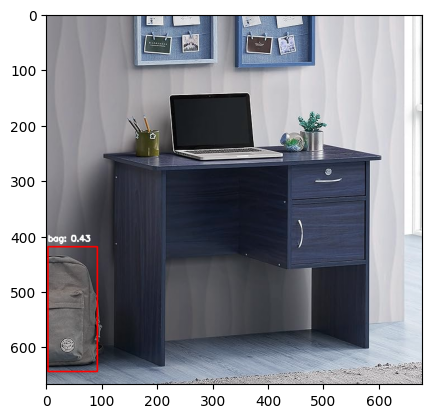

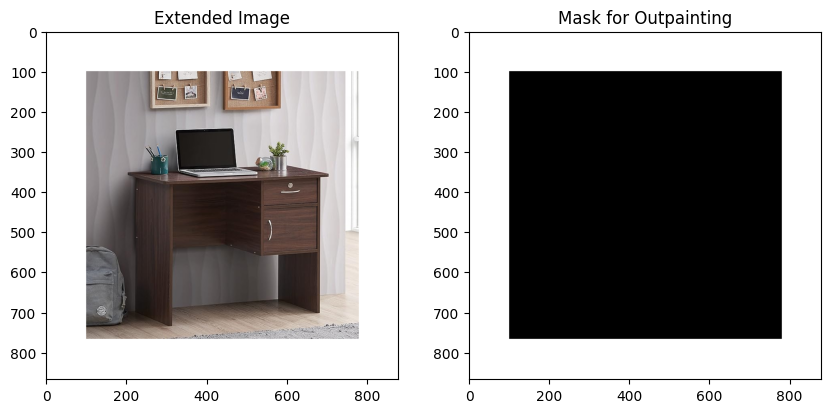

  0%|          | 0/50 [00:00<?, ?it/s]

runnning
runnning
runnning
Boxes length: 3, Detected Class IDs length: 3, Confidences length: 3, Indices length: 1
boxes [[11, 526, 193, 208], [33, 512, 162, 228], [34, 521, 160, 230]]


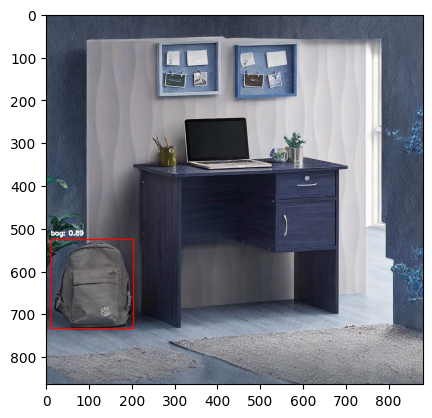

In [155]:
import cv2
import numpy as np
weights = "/kaggle/input/avataar/Avataar/yolov3.weights"
config = "/kaggle/input/avataar/Avataar/yolov3.cfg"
net = cv2.dnn.readNet(weights, config)
find_obj(img_choice, possible_classes, obj,0)

In [154]:
print(img_choice)

/kaggle/input/avataar/bagpack.jpg


In [153]:
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import numpy as np

model_type = "vit_h"
sam_checkpoint = "/kaggle/input/avataar/Avataar/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)



In [151]:
image = cv2.imread(img_choice)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image_rgb)


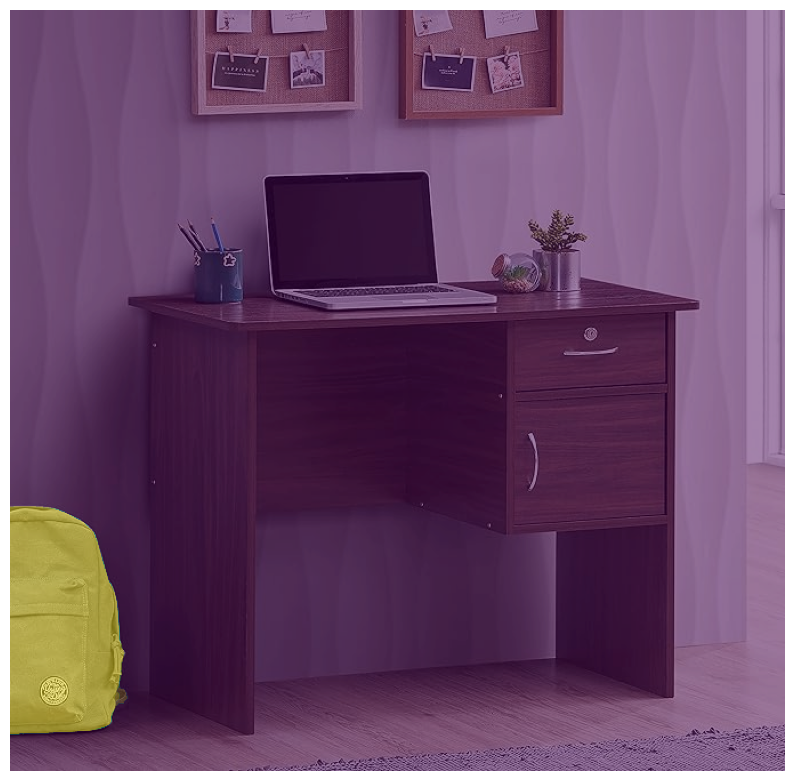

In [152]:
padding = 30
input_box = np.array([x-padding,y-padding,x+w+padding,y+h+padding])

input_box = torch.tensor(input_box).unsqueeze(0).numpy()

masks, _, _ = predictor.predict(box=input_box)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)

for mask in masks:
    plt.imshow(mask, alpha=0.2)

plt.axis('off')
plt.show()

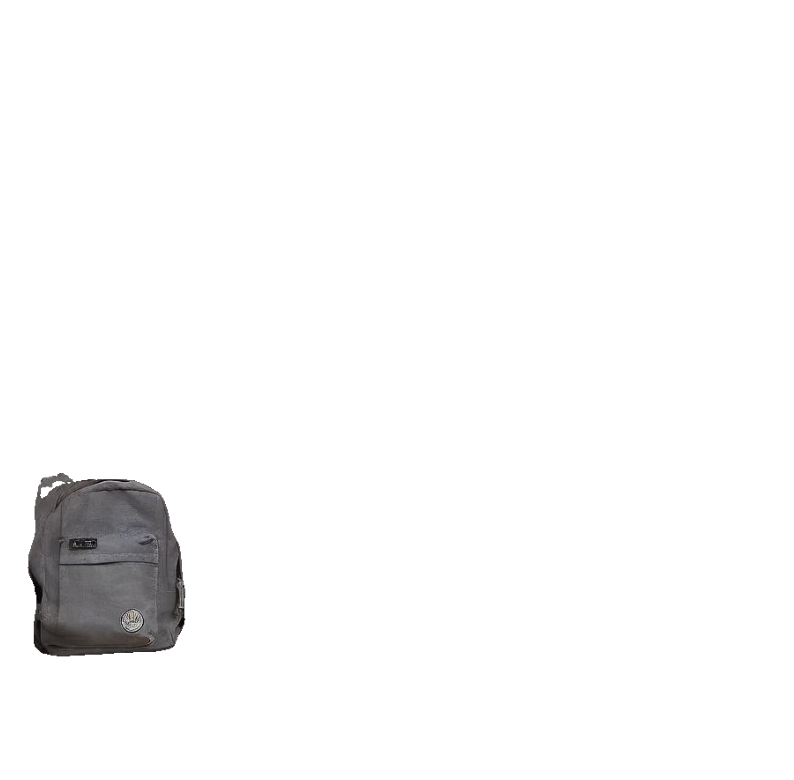

True

In [39]:
mask = masks[0]

height, width, _ = image_rgb.shape
subject_image_rgba = np.zeros((height, width, 4), dtype=np.uint8)

subject_image_rgba[..., :3] = np.where(mask[..., np.newaxis], image_rgb, 0)

subject_image_rgba[..., 3] = np.where(mask, 255, 0)

plt.figure(figsize=(10, 10))
plt.imshow(subject_image_rgba)
plt.axis('off')
plt.show()

cv2.imwrite("subject.png", cv2.cvtColor(subject_image_rgba, cv2.COLOR_RGBA2BGRA))

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.0 MB/s eta 0:00:00a 0:00:01


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280ae

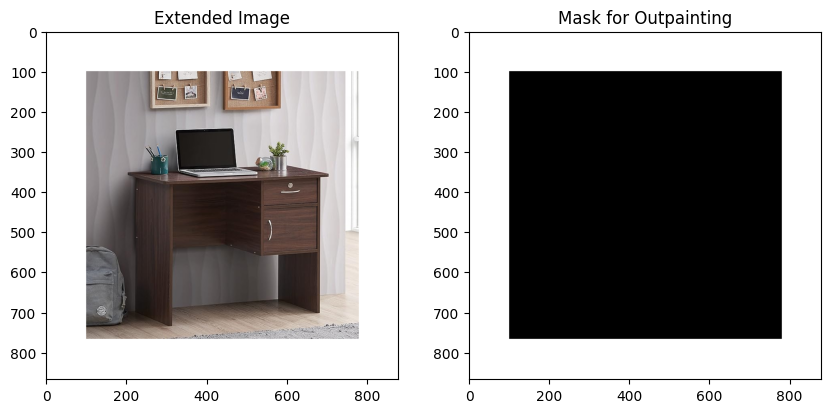

  0%|          | 0/50 [00:00<?, ?it/s]

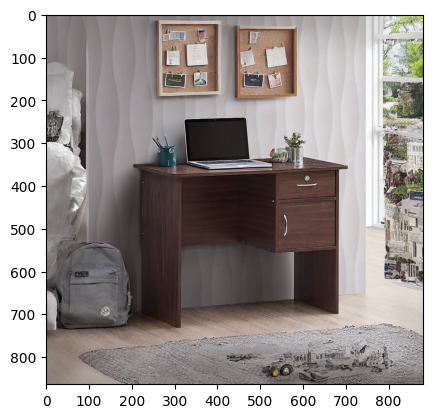

In [40]:

def cv2_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def pil_to_cv2(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

(864, 880)


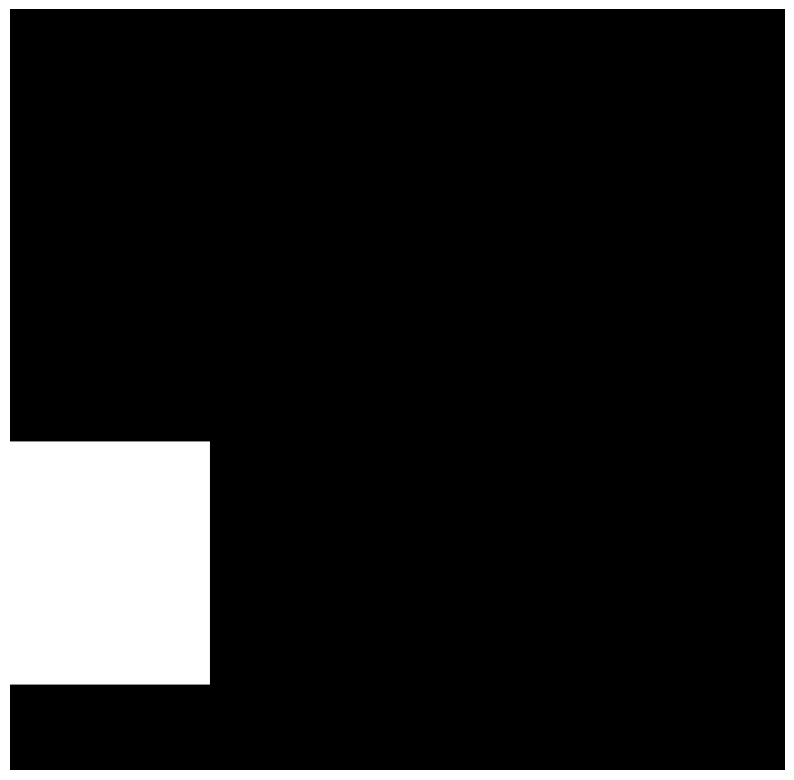

In [41]:
rect_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.uint8)
print(rect_mask.shape)
y0 = max(0,y-padding)
x0 = max(0, x-padding)
y1 = min((rect_mask.shape)[0],y+h+padding)
x1 = min((rect_mask.shape)[1],x+w+padding)
rect_mask[y0:y1, x0:x1] = 255

mask_pil = Image.fromarray(rect_mask)

plt.figure(figsize=(10, 10))
plt.imshow(mask_pil, cmap="gray")
plt.axis('off')
plt.show()


In [42]:
image_pil = Image.fromarray(image_rgb)

In [43]:
image_width = (image_pil.size)[0]
image_height = (image_pil.size)[1]
print(image_height, image_width)
aspect = image_width/image_height
print(16*round(image_height/16))

864 880
864


  0%|          | 0/50 [00:00<?, ?it/s]

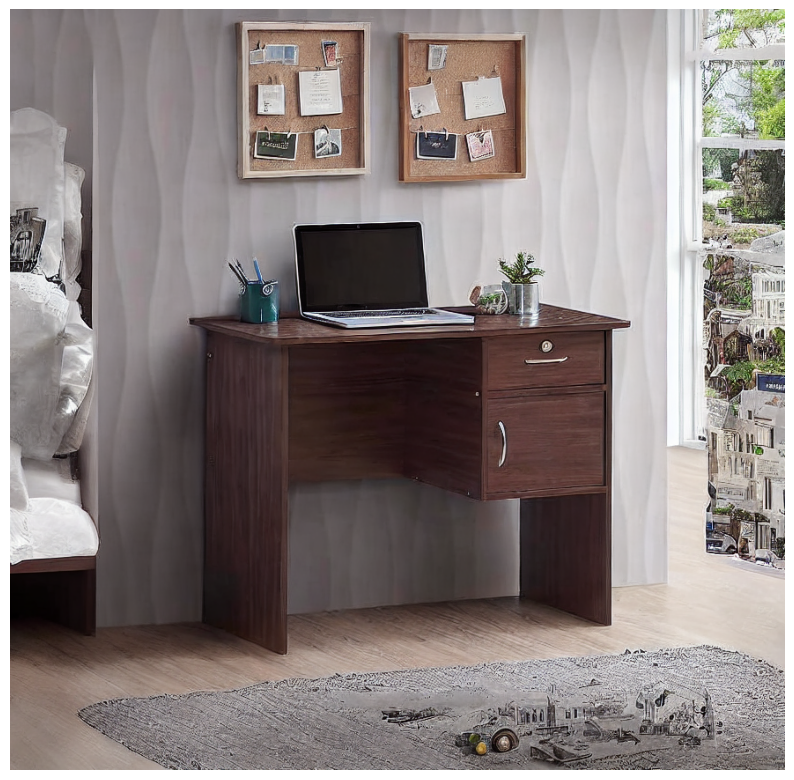

In [44]:
from matplotlib import pyplot as plt
prompt = "background"
negative_prompt = "objects, basket, person, book, lamp, vase, flower, tree, plant, photo, frame, anything, chair, sofa, couch, pen, penstand, stationary"

inpainted_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image_pil,
    mask_image=mask_pil,
    num_inference_steps=50,
    guidance_scale=8,
    height = 16*round(image_height/16),
    width = 16*round(image_width/16)

).images[0]

plt.figure(figsize=(10, 10))
plt.imshow(inpainted_image)
plt.axis('off')
plt.show()

inpainted_image.save("final_inpainted_image.jpg")

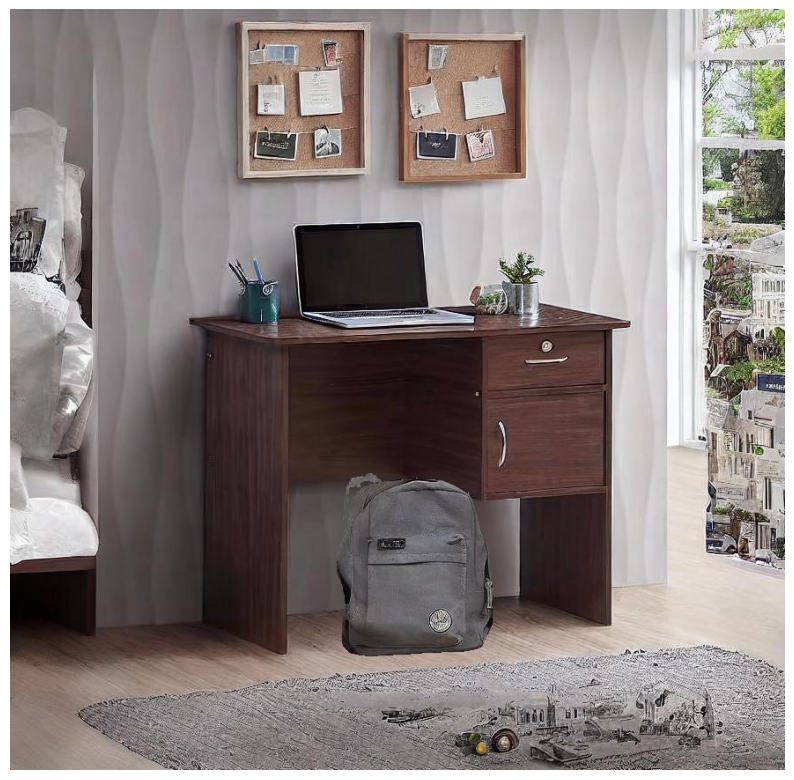

In [48]:
from PIL import Image

final_inpainted_image = Image.open("/kaggle/working/final_inpainted_image.jpg")

subject_image = Image.open("/kaggle/working/subject.png")

final_image = final_inpainted_image.copy()
final_image.paste(subject_image, (350, 0), subject_image)

plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis('off')
plt.show()
final_image.save("final_image_with_subject.png")

In [51]:
width,height = final_image.size
print(width, height)

880 864


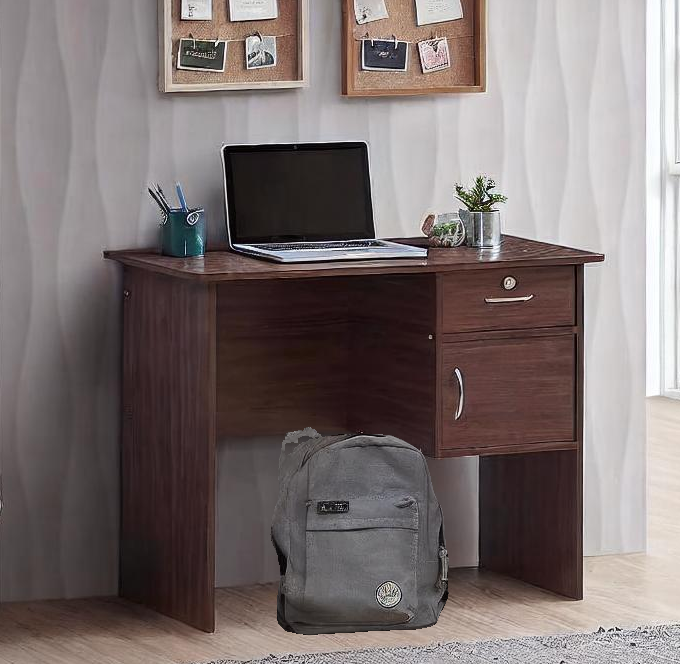

In [56]:

final_image.crop((100,100,(width-100),(height-100)))